In [1]:
import sys 
sys.path.append('../../')

In [2]:
import Helpers.helpers as helpers

plain_df = helpers.load_dataset('../export/plain.csv')
plain_df.head()

/opt/conda/lib/python3.9/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


,X,Y
0,0.290699,0.005919
1,-0.783091,-0.406766
2,0.652456,-0.076586
3,-0.264127,0.038481
4,-0.444901,0.834250


In [3]:
from diffprivlib.mechanisms import laplace, gaussian

lp = laplace.Laplace(epsilon=3, sensitivity=1)
lp.randomise(2)

1.9430261541175275

In [4]:
gs = gaussian.GaussianAnalytic(epsilon=3, sensitivity=1, delta=0.1)
gs.randomise(1)

2.35283660959042

In [5]:
from matplotlib import pyplot as plt
import numpy as np


def ls_at_distance(df, u, k):
    print(f'Computing local sensitivity for k = {k}')
    print(len(df) - k + 1)
    val = len(df) - k + 1
    return np.abs(u/val if val > 0 else 1)

#Smooth sensitivity and sampling in private data analysis.
def calc_smooth_sensitivity(X, u): 
    epsilon = 1           # set epsilon = 1
    delta = 1/len(X)**2  # set delta = 1/n^2

    # Step 1: set beta
    beta = epsilon / (2*np.log(2/delta))

    # Step 2: compute smoothed-out sensitivity for various values of k
    r = [np.exp(- beta * k) * ls_at_distance(X, u, k) for k in range(0,50)]
    plt.plot(r);
    plt.xlabel('Value of k')
    plt.ylabel('Smoothed-out Local Sensitivity');

    S = np.max(r)
    sensitivity = 2*S
    print(f'Final sensitivity: {sensitivity}')

Computing local sensitivity for k = 0
51
Computing local sensitivity for k = 1
50
Computing local sensitivity for k = 2
49
Computing local sensitivity for k = 3
48
Computing local sensitivity for k = 4
47
Computing local sensitivity for k = 5
46
Computing local sensitivity for k = 6
45
Computing local sensitivity for k = 7
44
Computing local sensitivity for k = 8
43
Computing local sensitivity for k = 9
42
Computing local sensitivity for k = 10
41
Computing local sensitivity for k = 11
40
Computing local sensitivity for k = 12
39
Computing local sensitivity for k = 13
38
Computing local sensitivity for k = 14
37
Computing local sensitivity for k = 15
36
Computing local sensitivity for k = 16
35
Computing local sensitivity for k = 17
34
Computing local sensitivity for k = 18
33
Computing local sensitivity for k = 19
32
Computing local sensitivity for k = 20
31
Computing local sensitivity for k = 21
30
Computing local sensitivity for k = 22
29
Computing local sensitivity for k = 23
28
Co

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


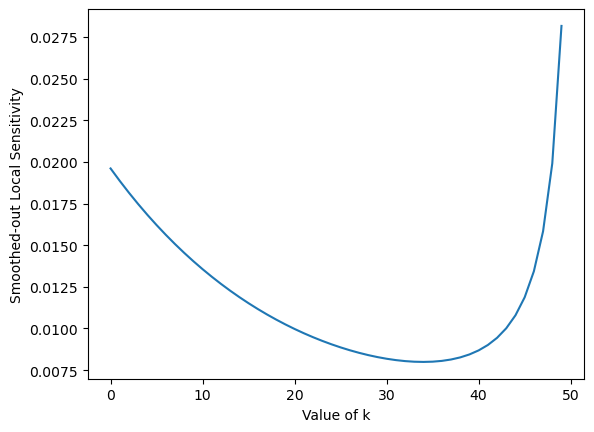

In [6]:
u = np.max(plain_df).max()
calc_smooth_sensitivity(plain_df, u)
sensitivity = 0.507

In [7]:
import numpy as np

# [https://github.com/forestneo/sunPytools/blob/master/dplib/ldp_mechanisms/piecewise_mechanism.py](https://github.com/forestneo/sunPytools/blob/master/dplib/ldp_mechanisms/piecewise_mechanism.py)
# Collecting and Analyzing Multidimensional Data with Local Differential Privacy
def randomize_piece_wise(epsilon, value):
    z = np.e ** (epsilon / 2)
    C = (z + 1) / (z - 1)
    P1 = (value + 1) / (2 + 2 * z)
    P2 = z / (z + 1)
    P3 = (1 - value) / (2 + 2 * z)

    g1 = (C + 1) * value / 2 - (C - 1) / 2
    g2 = (C + 1) * value / 2 + (C - 1) / 2

    rnd = np.random.random()
    if rnd < P1:
        result = -C + np.random.random() * (g1 - (-C))
    elif rnd < P1 + P2:
        result = (g2 - g1) * np.random.random() + g1
    else:
        result = (C - g2) * np.random.random() + g2
    return result


In [8]:
from Helpers.pairwise import PMBase, PiecewiseMechanism
pm_encoder = PMBase(epsilon=10)
pm_encoder.randomise(1)

1.0042220995980224

## Generate data

In [9]:
def generate_pairwise_perturbation(plain_df, epsilon):
    max = plain_df.max().max()
    min = plain_df.min().min()
    pm_encoder = PiecewiseMechanism(epsilon=epsilon,domain=(min, max))
    perturbed_df = plain_df.copy()
    for col in plain_df.columns:
        perturbed_df[col] = plain_df[col].apply(pm_encoder.randomise)
    return perturbed_df

def generate_laplace_perturbation(plain_df, epsilon):
    max = plain_df.max().max()
    min = plain_df.min().min()
    lp = laplace.Laplace(epsilon=epsilon, sensitivity=sensitivity)
    perturbed_df = plain_df.copy()
    for col in plain_df.columns:
        perturbed_df[col] = plain_df[col].apply(lambda x: lp.randomise(x))
    return perturbed_df

def generate_gaussian_perturbation(plain_df, epsilon):
    max = plain_df.max().max()
    min = plain_df.min().min()
    gs = gaussian.GaussianAnalytic(epsilon=epsilon, sensitivity=sensitivity, delta=0.1)
    perturbed_df = plain_df.copy()
    for col in plain_df.columns:
        perturbed_df[col] = plain_df[col].apply(lambda x: gs.randomise(x))
    return perturbed_df

In [10]:
plain_df.head()

,X,Y
0,0.290699,0.005919
1,-0.783091,-0.406766
2,0.652456,-0.076586
3,-0.264127,0.038481
4,-0.444901,0.834250


In [11]:
generate_pairwise_perturbation(plain_df, epsilon=7).head()

,X,Y
0,0.296877,0.032504
1,-0.806907,-0.391073
2,0.702249,-0.105936
3,-0.264682,0.035551
4,-0.459755,0.864845


In [12]:
generate_laplace_perturbation(plain_df=plain_df, epsilon=0.5).head()

,X,Y
0,1.351916,0.529284
1,-1.536214,0.973563
2,0.176625,-0.919433
3,0.500949,1.385271
4,0.181589,0.693648


In [13]:
generate_gaussian_perturbation(plain_df=plain_df, epsilon=0.5).head()

,X,Y
0,-0.680914,-0.653060
1,-1.198289,-0.133285
2,1.097776,-1.339362
3,0.987549,-1.448622
4,-1.391130,0.368152


In [14]:
import pandas as pd

epsilons = [0.05, 0.1 , 0.5 , 1, 2, 3, 5, 7, 9]
for epsilon in epsilons:
    Z = generate_pairwise_perturbation(plain_df, epsilon)
    Z_gaussian = generate_gaussian_perturbation(plain_df, epsilon)
    Z_laplace = generate_laplace_perturbation(plain_df, epsilon)
    Z_pd = pd.DataFrame(Z, columns=['X', 'Y'])
    Z_gaussian_pd = pd.DataFrame(Z_gaussian, columns=['X', 'Y'])
    Z_laplace_pd = pd.DataFrame(Z_laplace, columns=['X', 'Y'])
    Z_pd.to_csv('../export/pairwise/perturbed_'+str(epsilon)+'.csv')
    Z_gaussian_pd.to_csv('../export/gaussian/perturbed_'+str(epsilon)+'.csv')
    Z_laplace_pd.to_csv('../export/laplace/perturbed_'+str(epsilon)+'.csv')